In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.calibration import calibration_curve
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

In [2]:
data = pd.read_csv("dataset.csv")

In [50]:
data[['release_date']]

,release_date
0,1994-09-23
1,1995-10-19
2,1972-03-14
3,1993-12-15
4,1974-12-20
...,...
9980,2010-06-30
9981,2015-07-22
9982,1990-12-14
9983,2007-11-29


In [4]:
len(data)

10000

In [5]:
nan_in_df = data.isna().any().any()
print("Are there any NaN values in the DataFrame?", nan_in_df)

nan_columns = data.isna().any()
print("Columns with NaN values:", nan_columns[nan_columns].index.tolist())

Are there any NaN values in the DataFrame? True
Columns with NaN values: ['genre', 'overview']


In [6]:
data = data.dropna(subset=['genre', "overview"])

In [7]:
# Split the genre into lists
data['genre_list'] = data['genre'].apply(lambda x: x.split(','))

/tmp/ipykernel_23143/2585905048.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['genre_list'] = data['genre'].apply(lambda x: x.split(','))


In [8]:
data['genre_list'].tail()

9995                         [Action, Adventure, Fantasy]
9996    [Action, TV Movie, Science Fiction, Comedy, Ad...
9997                       [Action, Science Fiction, War]
9998                  [Adventure, Fantasy, Action, Drama]
9999                            [Thriller, Action, Crime]
Name: genre_list, dtype: object

In [9]:
data = data.reset_index(drop=True)

In [10]:
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(data['genre_list']), columns=mlb.classes_)

# Merge back with original DataFrame
data = data.join(genre_encoded)

In [11]:
data.columns

Index(['id', 'title', 'genre', 'original_language', 'overview', 'popularity',
       'release_date', 'vote_average', 'vote_count', 'genre_list', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family',
       'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
       'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western'],
      dtype='object')

In [12]:
data[['Action', 'Adventure',
       'Animation', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western']].tail(5)

,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
9980,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9981,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0
9982,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
9983,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
9984,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [13]:
# Label Encode 'original_language'
label_encoder = LabelEncoder()
data['original_language_encoded'] = label_encoder.fit_transform(data['original_language'])

In [14]:
data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')

data['release_year'] = data['release_date'].dt.year
data['release_month'] = data['release_date'].dt.month
data['release_day'] = data['release_date'].dt.day

In [15]:
data.columns

Index(['id', 'title', 'genre', 'original_language', 'overview', 'popularity',
       'release_date', 'vote_average', 'vote_count', 'genre_list', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family',
       'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
       'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western',
       'original_language_encoded', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [16]:
cols = ['popularity', 'vote_count', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family',
       'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
       'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western',
       'original_language_encoded', 'release_year', 'release_month',
       'release_day']
X = data[cols]

In [17]:
X

,popularity,vote_count,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,...,Romance,Science Fiction,TV Movie,Thriller,War,Western,original_language_encoded,release_year,release_month,release_day
0,94.075,21862,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,10,1994,9,23
1,25.408,3731,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,18,1995,10,19
2,90.585,16280,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,10,1972,3,14
3,44.761,12959,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,10,1993,12,15
4,57.749,9811,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,10,1974,12,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980,98.322,3347,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,10,2010,6,30
9981,12.490,417,1,1,0,1,0,0,0,0,...,0,1,1,0,0,0,10,2015,7,22
9982,18.333,332,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,10,1990,12,14
9983,15.159,668,1,1,0,0,0,1,0,1,...,0,0,0,0,0,0,10,2007,11,29


In [18]:
def categorize_vote_average(v):
    """
    Returns an integer for the category:
      0 => bad
      1 => good
    """
    if v < 6.5:
        return 0  # bad
    else:
        return 1  # good

data['vote_label'] = data['vote_average'].apply(categorize_vote_average)
y = data['vote_label']

In [54]:
data[['vote_average']]

,vote_average
0,8.7
1,8.7
2,8.7
3,8.6
4,8.6
...,...
9980,4.7
9981,4.7
9982,4.6
9983,4.7


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [21]:
# Put models in a dictionary
models = {"Decision Tree": DecisionTreeClassifier(),
          "Logistic Regression": LogisticRegression(max_iter=1000),}

# Create function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [22]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

/home/groups/CEDAR/kaoutar/programs/miniconda3/envs/tensorflow2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Decision Tree': 0.7035553329994992,
 'Logistic Regression': 0.7180771156735103}

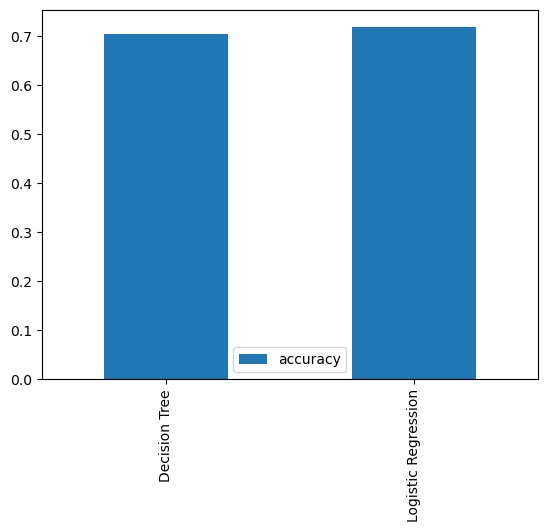

In [23]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar();

In [24]:
# Optimized parameter grid
log_reg_grid = {
    "C": np.logspace(-3, 3, 10),  # Reduced range of C
    "solver": ["liblinear", "lbfgs"],  # Best solvers for small/medium datasets
    "penalty": ["l1", "l2"],  # ElasticNet is rarely useful here
    "max_iter": [750, 1500, 2000]  # Set a reasonable iteration limit
}

# Initialize GridSearchCV
gs_log_reg = GridSearchCV(
    LogisticRegression(),
    param_grid=log_reg_grid,
    cv=5,  # Reduce cross-validation folds for speed
    verbose=1,
    scoring="accuracy",
    n_jobs=-1  # Use all cores for parallel processing
)

# Fit the model
gs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


/home/groups/CEDAR/kaoutar/programs/miniconda3/envs/tensorflow2/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
150 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/home/groups/CEDAR/kaoutar/programs/miniconda3/envs/tensorflow2/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/groups/CEDAR/kaoutar/programs/miniconda3/envs/tensorflow2/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/gr

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'max_iter': [750, 1500, 2000], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='accuracy', verbose=1)

In [25]:
print("Best Parameters:", gs_log_reg.best_params_)

print("Best Score:", gs_log_reg.best_score_)

Best Parameters: {'C': 215.44346900318823, 'max_iter': 1500, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.732724060993587


In [26]:
lr_model = LogisticRegression(**gs_log_reg.best_params_) 
lr_model.fit(X_train, y_train)

LogisticRegression(C=215.44346900318823, max_iter=1500, penalty='l1',
                   solver='liblinear')

In [27]:
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1] 

In [28]:
# Optimized parameter grid for Decision Tree
dt_grid = {
    "max_depth": [5, 10, 20, None],  # Control depth to prevent overfitting
    "min_samples_split": [5, 20, 30, 40, 50, 80],  # Minimum samples to split a node
    "min_samples_leaf": [1, 5, 10, 20],  # Minimum samples required at a leaf node
    "criterion": ["gini", "entropy"],  # Measure of split quality
    "max_features": ["sqrt", "log2", None]  # Feature selection strategies
}

# Initialize GridSearchCV
gs_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=dt_grid,
    cv=5,  # 5-fold cross-validation
    verbose=1,
    scoring="accuracy",  # Change to "roc_auc" if the dataset is imbalanced
    n_jobs=-1  # Use all CPU cores
)

# Fit the model
gs_dt.fit(X_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 5, 10, 20],
                         'min_samples_split': [5, 20, 30, 40, 50, 80]},
             scoring='accuracy', verbose=1)

In [29]:
print("Best Parameters:", gs_dt.best_params_)

print("Best Score:", gs_dt.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 80}
Best Score: 0.7477444802245763


In [30]:
dt_model = DecisionTreeClassifier(**gs_dt.best_params_)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=10, min_samples_split=80)

In [31]:
y_pred_dt = dt_model.predict(X_test)
y_prob_dt = dt_model.predict_proba(X_test)[:, 1]

In [32]:
def plot_learning_curve(estimator, X, y, label, color):
    """
    Plots a learning curve (train score vs. validation score)
    for a given estimator. Uses accuracy as scoring by default.
    """
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, scoring='accuracy', 
        shuffle=True,
        train_sizes=[0.1, 0.33, 0.55, 0.78, 1.], 
        random_state=42
    )
    
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    
    plt.plot(train_sizes, train_mean, 'o-', label=f"{label} Train", color=color)
    plt.plot(train_sizes, val_mean, 'o--', label=f"{label} Validation", color=color)

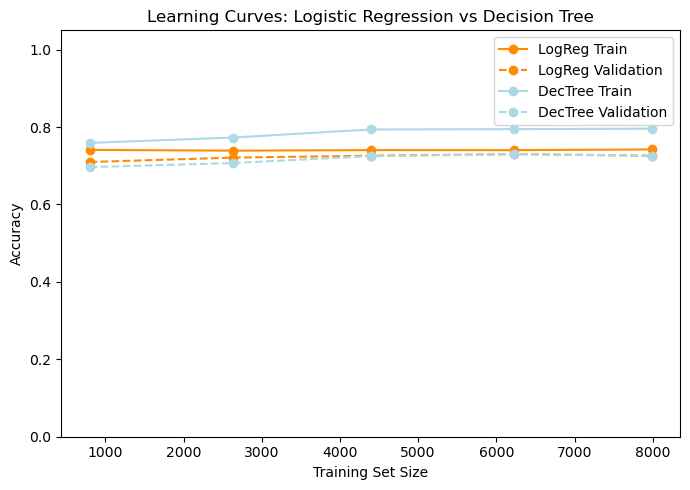

In [33]:
plt.figure(figsize=(7,5))

plot_learning_curve(lr_model, X, y, label="LogReg", color="darkorange")
plot_learning_curve(dt_model, X, y, label="DecTree", color="lightblue")

plt.title("Learning Curves: Logistic Regression vs Decision Tree")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.ylim([0,1.05])
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [34]:
def compute_metrics(y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_val = auc(fpr, tpr)
    return acc, prec, rec, f1, fpr, tpr, auc_val

def plot_conf_mat(ax, cm, title, cmap):
    sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap=cmap, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

In [35]:
acc_lr, prec_lr, rec_lr, f1_lr, fpr_lr, tpr_lr, auc_lr = compute_metrics(y_test, y_pred_lr, y_prob_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)

acc_dt, prec_dt, rec_dt, f1_dt, fpr_dt, tpr_dt, auc_dt = compute_metrics(y_test, y_pred_dt, y_prob_dt)
cm_dt = confusion_matrix(y_test, y_pred_dt)

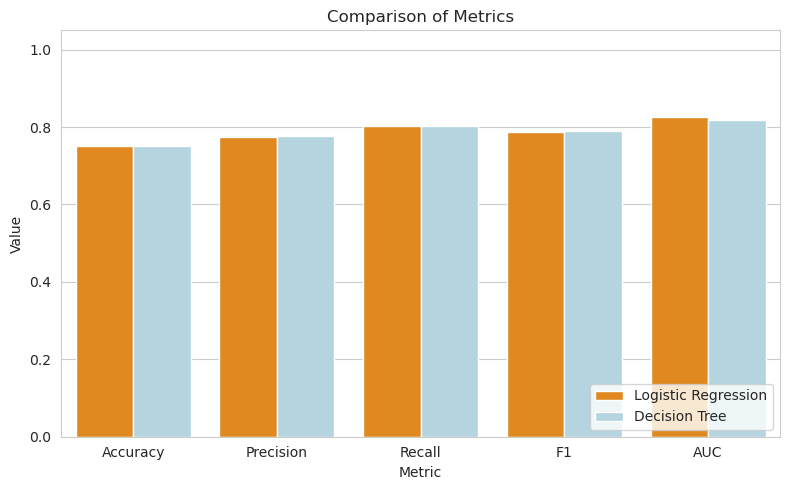

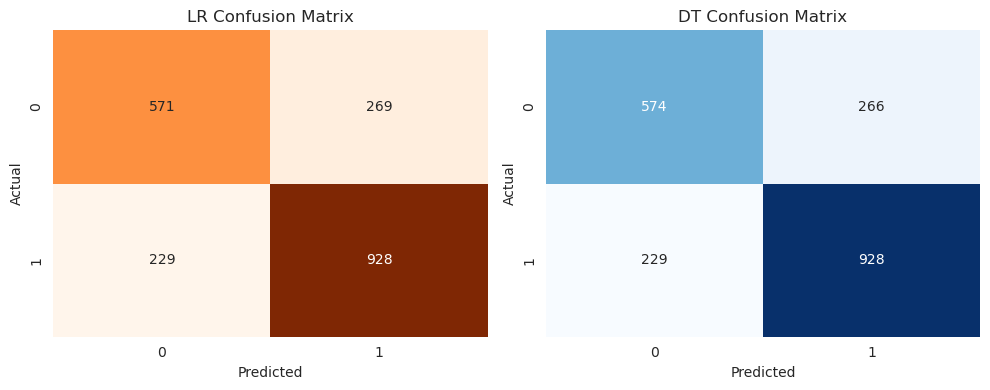

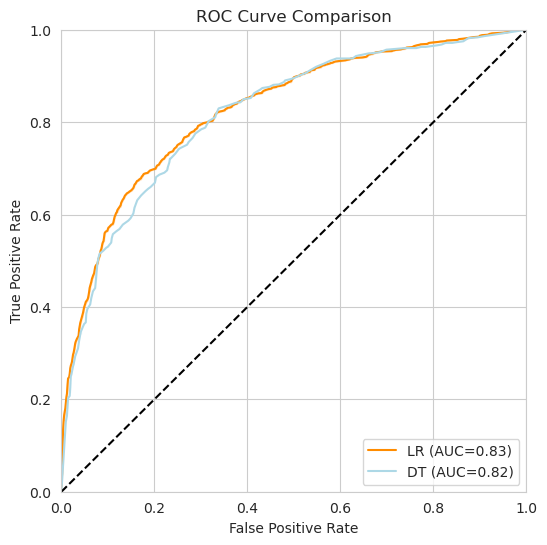

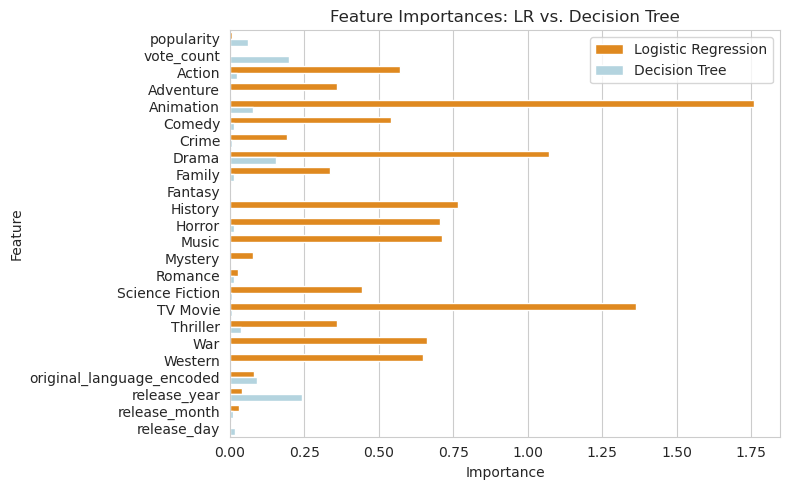

In [36]:
metrics = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
lr_values = [acc_lr, prec_lr, rec_lr, f1_lr, auc_lr]
dt_values = [acc_dt, prec_dt, rec_dt, f1_dt, auc_dt]

df_metrics = pd.DataFrame({
    "Metric": metrics * 2,
    "Value": lr_values + dt_values,
    "Model": ["Logistic Regression"]*len(metrics) + ["Decision Tree"]*len(metrics)
})

sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_metrics, x="Metric", y="Value", hue="Model",
            palette=["darkorange","lightblue"])
plt.ylim(0,1.05)
plt.title("Comparison of Metrics")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(10,4))


plot_conf_mat(axes[0], cm_lr, "LR Confusion Matrix", "Oranges")
plot_conf_mat(axes[1], cm_dt, "DT Confusion Matrix", "Blues")

plt.tight_layout()
plt.show()


plt.figure(figsize=(6,6))
# Logistic Regression
sns.lineplot(x=fpr_lr, y=tpr_lr, label=f"LR (AUC={auc_lr:.2f})", color="darkorange")
# Decision Tree
sns.lineplot(x=fpr_dt, y=tpr_dt, label=f"DT (AUC={auc_dt:.2f})", color="lightblue")
# Diagonal
plt.plot([0,1],[0,1],"k--")
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()


lr_coef = lr_model.coef_.flatten()  

fi_lr = np.abs(lr_coef)


fi_dt = dt_model.feature_importances_

df_fi = pd.DataFrame({
    "Feature": cols * 2,
    "Importance": np.concatenate([fi_lr, fi_dt]),
    "Model": ["Logistic Regression"]*len(cols) + ["Decision Tree"]*len(cols)
})

plt.figure(figsize=(8,5))
sns.barplot(data=df_fi, x="Importance", y="Feature", hue="Model",
            palette=["darkorange","lightblue"])
plt.title("Feature Importances: LR vs. Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [59]:
X_test2 = X_test.copy()

In [60]:
X_test2["lr_pred"] = y_pred_lr
X_test2["lr_prob"] = y_prob_lr
X_test2["dt_pred"] = y_pred_dt
X_test2["dt_prob"] = y_prob_dt

In [62]:
X_test2.columns

Index(['popularity', 'vote_count', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western', 'original_language_encoded',
       'release_year', 'release_month', 'release_day', 'lr_pred', 'lr_prob',
       'dt_pred', 'dt_prob'],
      dtype='object')

In [63]:
genres = [
    'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
    'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music',
    'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
    'Thriller', 'War', 'Western'
]

# Choose a probability threshold (example: 0.7)
prob_threshold = 0.7

In [71]:
# Filter LR = 1, with high probability
df_lr_high = X_test2[(X_test2['lr_pred'] == 1) & (X_test2['lr_prob'] >= prob_threshold)]

# Melt the DataFrame so each genre is in its own row
df_lr_melted = df_lr_high.melt(
    id_vars=['lr_prob'],          # keep LR probability
    value_vars=genres,           # columns to unpivot
    var_name='genre',            # new column name for genre
    value_name='is_in_genre'     # 0/1 if the movie belongs to that genre
)

# Keep only rows where the movie *actually has* that genre
df_lr_melted = df_lr_melted[df_lr_melted['is_in_genre'] == 1]

In [72]:
genre_counts_lr = (
    df_lr_melted.groupby('genre')
    .size()                   # how many rows per genre
    .sort_values(ascending=False)
)

In [73]:
# Filter DT = 1, with high probability
df_dt_high = X_test2[(X_test2['dt_pred'] == 1) & (X_test2['dt_prob'] >= prob_threshold)]

# Melt
df_dt_melted = df_dt_high.melt(
    id_vars=['dt_prob'],
    value_vars=genres,
    var_name='genre',
    value_name='is_in_genre'
)

df_dt_melted = df_dt_melted[df_dt_melted['is_in_genre'] == 1]

# Count
genre_counts_dt = (
    df_dt_melted.groupby('genre')
    .size()
    .sort_values(ascending=False)
)

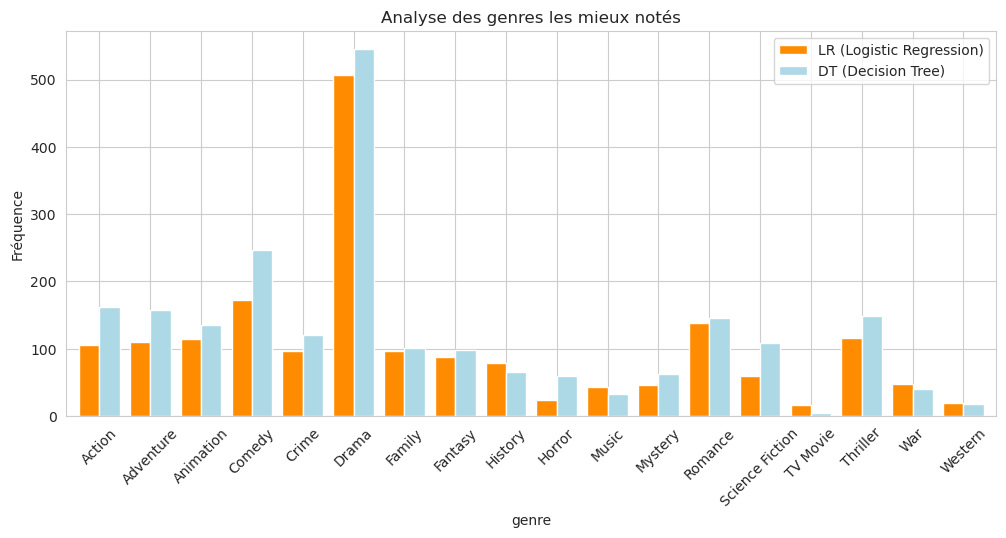

In [76]:
# Convert to DataFrame
compare_df = pd.DataFrame({
    'LR': genre_counts_lr,
    'DT': genre_counts_dt
}).fillna(0)

# Define colors
colors = ["darkorange", "lightblue"]

# Plot
compare_df.plot(
    kind='bar',
    figsize=(12, 5),
    width=0.8,
    color=colors  
)

plt.title("Analyse des genres les mieux notés")
plt.ylabel("Fréquence")
plt.xticks(rotation=45)
plt.legend(["LR (Logistic Regression)", "DT (Decision Tree)"])
plt.show()
